In [ ]:
from inho_function import rawdata_to_cleandata,txt_to_pkl_tokens

In [ ]:
name_list =  ['나의백수','앵무새죽이기_허퍼리','어린왕자','우리들의행복한시간','키다리_아저씨']

for file_name in name_list:
    rawdata_to_cleandata(f'no_han_book/{file_name}')
for file_name in name_list:
    txt_to_pkl_tokens(f'no_han_book/{file_name}')

In [2]:
for file_name in name_list:
    pkl_token_to_vectoredata(f'no_han_book/{file_name}.pkl',f'{file_name}')

단어 벡터화 중: 100%|██████████| 4150/4150 [00:00<00:00, 1025290.78it/s]


In [ ]:
name_list =  ['검은사슴','그대의차가운손','채식주의자','희랍어시간']

for file_name in name_list:
    rawdata_to_cleandata(f'han_book/{file_name}')
for file_name in name_list:
    txt_to_pkl_tokens(f'han_book/{file_name}')


 92%|█████████▏| 8564/9330 [01:01<00:05, 137.29it/s]

In [ ]:
for file_name in name_list:
    pkl_token_to_vectoredata(f'han_book/{file_name}.pkl',f'{file_name}')

In [12]:
import pickle
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE  # 또는 from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
import re

from matplotlib import font_manager, rc
font_path = "NanumGothic.ttf" # Windows 예시
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [13]:
model_path = "no_han_book/cc.ko.300.kv" # 사용자의 .kv 모델 경로
# 또는 model_path = "no_han_book/cc.ko.300.bin" # FastText 모델 직접 사용 시
# Gensim KeyedVectors 모델 로드
model = KeyedVectors.load(model_path, mmap='r') # mmap='r'은 메모리 효율적 로드
print("Gensim KeyedVectors 모델 로드 완료.")
# model_vocab = model.key_to_index # Gensim 4.x 이상
model_vocab = model.index_to_key # 또는 model.wv.index_to_key (버전 확인 필요)

Gensim KeyedVectors 모델 로드 완료.


In [14]:
def load_tokens_from_pkl(pkl_path):
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    all_tokens = []
    for entry in data:
        all_tokens.extend(entry.get('tokens', []))
    return all_tokens
    
tokens_A = load_tokens_from_pkl('no_han_book/어린왕자.pkl')
tokens_B = load_tokens_from_pkl('no_han_book/키다리_아저씨.pkl')



In [15]:
def get_top_n_words(tokens, n=100):
    # 빈도수 계산
    counts = Counter(tokens)
    # 빈도수 높은 순으로 정렬하고, 모델에 있는 단어만 필터링
    top_words = []
    # Gensim KeyedVectors 사용 시
    if hasattr(model, 'key_to_index') or hasattr(model, 'index_to_key'):
        model_vocab_set = set(model.index_to_key) # Gensim 4.x 이상 or model.wv.index_to_key
        for word, _ in counts.most_common():
            if word in model_vocab_set:
                top_words.append(word)
                if len(top_words) == n:
                    break
    # FastText 모델 직접 사용 시
    elif hasattr(model, 'get_words'):
         model_vocab_set = set(model.get_words())
         for word, _ in counts.most_common():
             if word in model_vocab_set: # FastText는 OOV 처리가 될 수도 있지만, 명시적으로 확인
                 top_words.append(word)
                 if len(top_words) == n:
                    break
    else:
        print("모델 타입 인식 불가.")
        return []

    return top_words

top_words_A = get_top_n_words(tokens_A, n=100)
top_words_B = get_top_n_words(tokens_B, n=100)

# 두 그룹 간 겹치지 않는 단어만 사용하거나, 겹치는 단어는 별도 표시 가능
# 여기서는 간단하게 합치되, 출처를 기억
words_to_visualize = []
groups = [] # 'A' 또는 'B' 레이블 저장

for word in top_words_A:
    if word not in words_to_visualize: # 중복 추가 방지
         words_to_visualize.append(word)
         groups.append('A')
for word in top_words_B:
    if word not in words_to_visualize: # 중복 추가 방지
         words_to_visualize.append(word)
         groups.append('B')
    # 만약 겹치는 단어도 포함하고 싶다면, 그룹 정보를 다르게 처리해야 함
    # 예: words_to_visualize.append(word); groups.append('B' if word not in top_words_A else 'Both')

print(f"시각화 대상 단어 수: {len(words_to_visualize)}")

시각화 대상 단어 수: 196


In [16]:
word_vectors = []
valid_words = []
valid_groups = []

for word, group in zip(words_to_visualize, groups):
    try:
        # Gensim KeyedVectors 사용 시
        if hasattr(model, 'key_to_index') or hasattr(model, 'index_to_key'):
             vector = model[word]
        # FastText 모델 직접 사용 시
        elif hasattr(model, 'get_word_vector'):
             vector = model.get_word_vector(word)
        else:
             print(f"모델 타입 인식 불가: {word} 스킵")
             continue

        word_vectors.append(vector)
        valid_words.append(word)
        valid_groups.append(group)

    except KeyError:
        # 이 경우는 get_top_n_words에서 필터링 했으므로 발생하지 않아야 함
        print(f"경고: 단어 '{word}'가 모델에 없습니다. (선정 로직 확인 필요)")
    except Exception as e:
        print(f"벡터 추출 오류 ({word}): {e}")


if not word_vectors:
    print("유효한 단어 벡터를 추출하지 못했습니다. 프로그램을 종료합니다.")
    exit()

word_vectors_np = np.array(word_vectors)
print(f"추출된 벡터 수: {len(word_vectors_np)}")

추출된 벡터 수: 196


In [17]:
# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate='auto')
# perplexity 값 (보통 5-50)이나 n_iter 값을 조절해보세요. 데이터가 많으면 시간이 오래 걸릴 수 있습니다.
# learning_rate='auto'는 최신 scikit-learn에서 권장됩니다.
try:
    vectors_2d = tsne.fit_transform(word_vectors_np)
    print("t-SNE 차원 축소 완료.")
except Exception as e:
    print(f"t-SNE 실행 중 오류: {e}")
    # PCA로 대체 시도
    try:
        from sklearn.decomposition import PCA
        print("PCA를 시도합니다.")
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(word_vectors_np)
        print("PCA 차원 축소 완료.")
    except Exception as e_pca:
        print(f"PCA 실행 중 오류: {e_pca}. 시각화를 진행할 수 없습니다.")
        exit()

c:\Users\USER\anaconda3\envs\py3.9\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 차원 축소 완료.


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

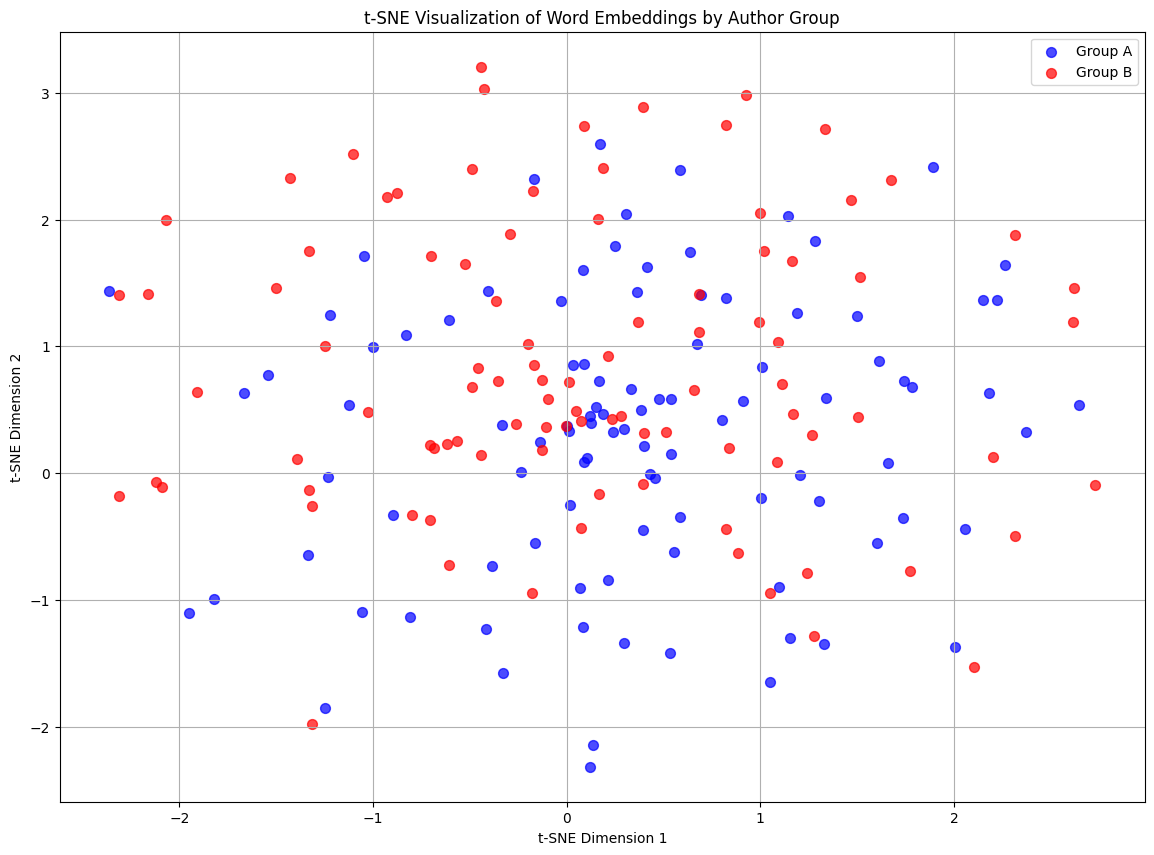

In [18]:
plt.figure(figsize=(14, 10))

# 그룹별로 점 찍기
unique_groups = sorted(list(set(valid_groups))) # ['A', 'B'] 또는 ['A', 'B', 'Both'] 등
colors = {'A': 'blue', 'B': 'red', 'Both': 'green'} # 그룹별 색상 지정

for group_label in unique_groups:
    indices = [i for i, g in enumerate(valid_groups) if g == group_label]
    if indices:
        plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1],
                    c=colors.get(group_label, 'gray'), # 정의되지 않은 그룹은 회색
                    label=f'Group {group_label}', alpha=0.7, s=50) # s는 점 크기

# (선택) 각 점에 단어 레이블 추가 (너무 많으면 지저분해짐)
# 특정 단어만 표시하거나, 확대 시 보이도록 인터랙티브 플롯 라이브러리(plotly, bokeh) 사용 고려
# for i, word in enumerate(valid_words):
#    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=9)

plt.title('t-SNE Visualization of Word Embeddings by Author Group')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import matplotlib 
matplotlib.matplotlib_fname()

'c:\\Users\\USER\\anaconda3\\envs\\py3.9\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc'